# APS Failure Prediction

Required installtions

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!pip3 install --upgrade xgboost

Requirement already up-to-date: xgboost in c:\users\hp\appdata\local\programs\python\python36\lib\site-packages (1.4.1)


You should consider upgrading via the 'c:\users\hp\appdata\local\programs\python\python36\python.exe -m pip install --upgrade pip' command.


In [ ]:
!pip3 install phik

You should consider upgrading via the 'c:\users\hp\appdata\local\programs\python\python36\python.exe -m pip install --upgrade pip' command.


### Imports

In [2]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import itertools
import pickle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
import os.path
from sklearn.utils import class_weight

### Extracting data from csv file

As the csv file contains some informations about the data before the actual dataset, we need to find the row number and starting from that row, we will extract data.

In [ ]:
def find_index(csv_file, input_text):
    """This function returns the row number in a csv file as the next row index of the input text
    """
    o = open(csv_file, 'r') 
    myData = csv.reader(o) 
    index = 1 
    for row in myData:
        if len(row) > 0 and input_text in str(row[0]): 
            return index+1 
        else : index+=1
start_row = find_index('aps_failure_training_set.csv', '----')

**Create dataframe from train and test csv files**

In [ ]:
train_data = pd.read_csv('aps_failure_training_set.csv', skiprows = start_row)
train_data.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,76698,na,2130706438,280,0,0,0,0,0,...,1240520,493384,721044,469792,339156,157956,73224,0,0,0
1,neg,33058,na,0,na,0,0,0,0,0,...,421400,178064,293306,245416,133654,81140,97576,1500,0,0
2,neg,41040,na,228,100,0,0,0,0,0,...,277378,159812,423992,409564,320746,158022,95128,514,0,0
3,neg,12,0,70,66,0,10,0,0,0,...,240,46,58,44,10,0,0,0,4,32
4,neg,60874,na,1368,458,0,0,0,0,0,...,622012,229790,405298,347188,286954,311560,433954,1218,0,0


In [ ]:
print(train_data.shape)

(60000, 171)


In [ ]:
test_data = pd.read_csv('aps_failure_test_set.csv', skiprows = start_row)
test_data.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,60,0,20,12,0,0,0,0,0,...,1098,138,412,654,78,88,0,0,0,0
1,neg,82,0,68,40,0,0,0,0,0,...,1068,276,1620,116,86,462,0,0,0,0
2,neg,66002,2,212,112,0,0,0,0,0,...,495076,380368,440134,269556,1315022,153680,516,0,0,0
3,neg,59816,na,1010,936,0,0,0,0,0,...,540820,243270,483302,485332,431376,210074,281662,3232,0,0
4,neg,1814,na,156,140,0,0,0,0,0,...,7646,4144,18466,49782,3176,482,76,0,0,0


In [ ]:
print(test_data.shape)

(16000, 171)


### Convert string categorical data to numeric

In [ ]:
train_data.loc[train_data['class'] == 'neg', 'class'] = 0
train_data.loc[train_data['class'] == 'pos', 'class'] = 1

train_data['class'].value_counts()

0    59000
1     1000
Name: class, dtype: int64

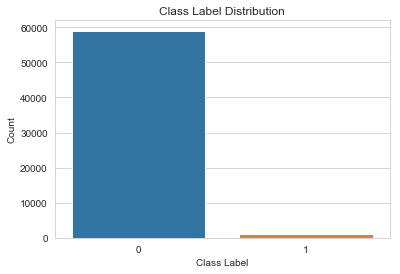

In [ ]:
# Class label distribution in train set
sns.barplot(train_data['class'].unique(),train_data['class'].value_counts())
plt.title('Class Label Distribution')
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.show()

In [ ]:
test_data.loc[test_data['class'] == 'neg', 'class'] = 0
test_data.loc[test_data['class'] == 'pos', 'class'] = 1

test_data['class'].value_counts()

0    15625
1      375
Name: class, dtype: int64

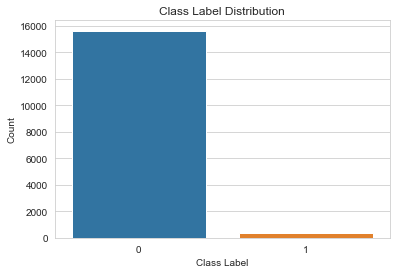

In [ ]:
# Class label distribution in train set
sns.barplot(test_data['class'].unique(),test_data['class'].value_counts())
plt.title('Class Label Distribution')
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.show()

From the above counts of class labels, we can see the datasets are an imbalanced datasets.

## Handling NaN values

### Converting 'na' to NaN

As the NaN are represented as strings ('na'), we need to convert 'na' to NaN, so that we can do preprocessing on NaN elements.

In [ ]:
train_data.replace(to_replace = 'na',
                 value = np.NaN, inplace = True)
test_data.replace(to_replace = 'na',
                 value = np.NaN, inplace = True)

In [ ]:
train_data.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,0,76698,NaN,2130706438,280,0,0,0,0,0,...,1240520,493384,721044,469792,339156,157956,73224,0,0,0
1,0,33058,NaN,0,NaN,0,0,0,0,0,...,421400,178064,293306,245416,133654,81140,97576,1500,0,0
2,0,41040,NaN,228,100,0,0,0,0,0,...,277378,159812,423992,409564,320746,158022,95128,514,0,0
3,0,12,0,70,66,0,10,0,0,0,...,240,46,58,44,10,0,0,0,4,32
4,0,60874,NaN,1368,458,0,0,0,0,0,...,622012,229790,405298,347188,286954,311560,433954,1218,0,0


In [ ]:
test_data.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,0,60,0,20,12,0,0,0,0,0,...,1098,138,412,654,78,88,0,0,0,0
1,0,82,0,68,40,0,0,0,0,0,...,1068,276,1620,116,86,462,0,0,0,0
2,0,66002,2,212,112,0,0,0,0,0,...,495076,380368,440134,269556,1315022,153680,516,0,0,0
3,0,59816,NaN,1010,936,0,0,0,0,0,...,540820,243270,483302,485332,431376,210074,281662,3232,0,0
4,0,1814,NaN,156,140,0,0,0,0,0,...,7646,4144,18466,49782,3176,482,76,0,0,0


In [ ]:
test_data

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,0,60,0,20,12,0,0,0,0,0,...,1098,138,412,654,78,88,0,0,0,0
1,0,82,0,68,40,0,0,0,0,0,...,1068,276,1620,116,86,462,0,0,0,0
2,0,66002,2,212,112,0,0,0,0,0,...,495076,380368,440134,269556,1315022,153680,516,0,0,0
3,0,59816,NaN,1010,936,0,0,0,0,0,...,540820,243270,483302,485332,431376,210074,281662,3232,0,0
4,0,1814,NaN,156,140,0,0,0,0,0,...,7646,4144,18466,49782,3176,482,76,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15995,0,81852,NaN,2130706432,892,0,0,0,0,0,...,632658,273242,510354,373918,349840,317840,960024,25566,0,0
15996,0,18,0,52,46,8,26,0,0,0,...,266,44,46,14,2,0,0,0,0,0
15997,0,79636,NaN,1670,1518,0,0,0,0,0,...,806832,449962,778826,581558,375498,222866,358934,19548,0,0
15998,0,110,NaN,36,32,0,0,0,0,0,...,588,210,180,544,1004,1338,74,0,0,0


### Checking NaN values in columns

**Checking NaN values for columns in train set**

In [ ]:
nan_percentage_train_col = train_data.isna().sum().values / train_data.shape[0]
nan_percentage_train_col = np.round(nan_percentage_train_col,2) * 100
nan_percentage_train_col = nan_percentage_train_col.astype('int64')
nan_percentage_train_col.shape

(171,)

In [ ]:
# Create dict using column names and NaN percentage values and sort it
nan_percentage_train_col_dict = dict(zip(train_data.columns, nan_percentage_train_col))
nan_percentage_train_col_dict = {k: v for k, v in sorted(nan_percentage_train_col_dict.items(), key=lambda item: item[1],reverse=True)}

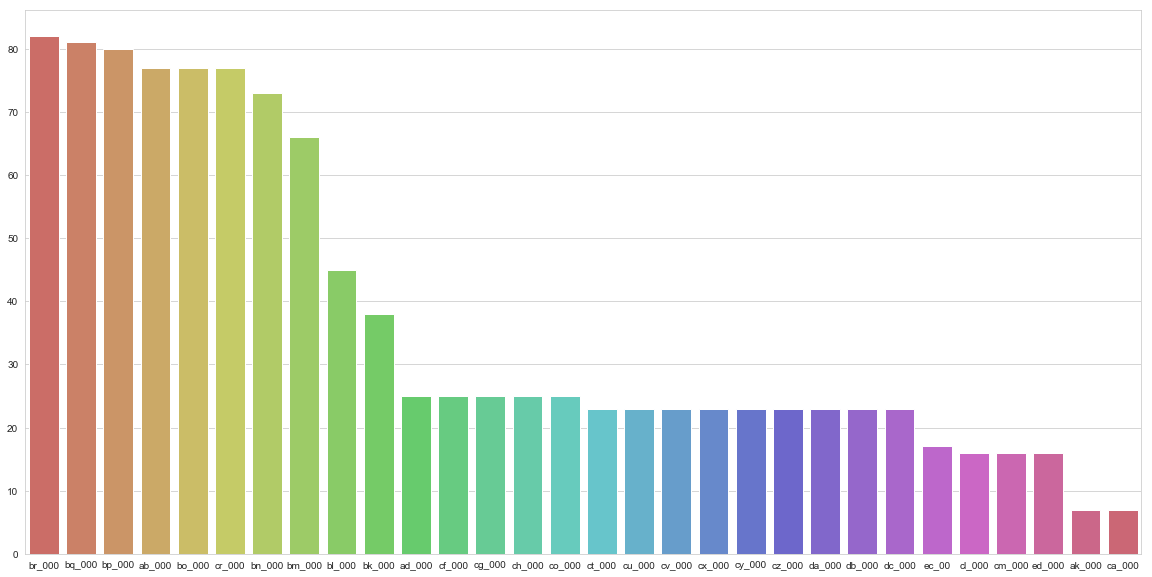

In [ ]:
# Filtering out columns with less nan values for future use
sns.set_style(style="whitegrid")
plt.figure(figsize=(20,10))
plot = sns.barplot(x= list(nan_percentage_train_col_dict.keys())[:30],y = list(nan_percentage_train_col_dict.values())[:30],palette="hls")
plt.show()

Except 1st 10 columns as shown in above plot, rest all the columns has NaN values less than 30%. The columns with less NaN values can be more useful than others.

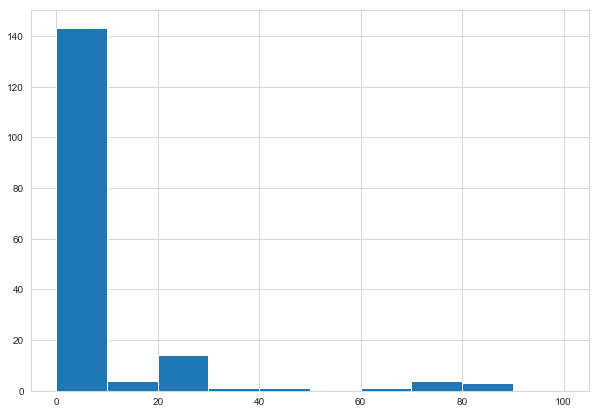

In [ ]:
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(nan_percentage_train_col, bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
plt.show()

We can see, there are 7 columns each having more 70% NaN values. So we can remove the columns having 70% or more NaN values. 

### Checking NaN values in rows

**Checking NaN values for rows in train set**

In [ ]:
nan_percentage_train_row = train_data.isna().sum(axis=1).values / train_data.shape[1]
nan_percentage_train_row = np.round(nan_percentage_train_row,2) * 100
nan_percentage_train_row = nan_percentage_train_row.astype('int64')
nan_percentage_train_row.shape

(60000,)

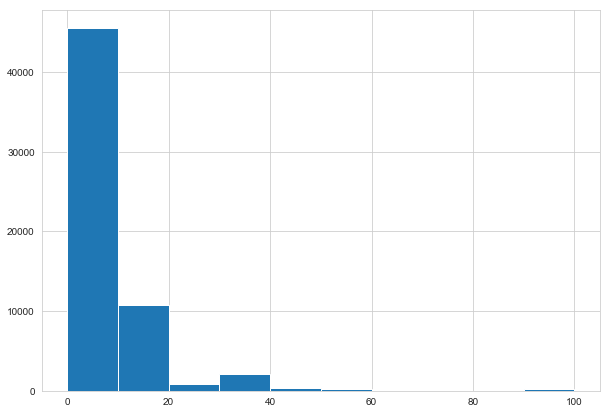

In [ ]:
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(nan_percentage_train_row, bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
plt.show()

We can see there can be few data points having 90-100 percentage of NaN values in train set. 

## Data Preprocessing

In [ ]:
columns = train_data.columns[1:]

### Replce NaN values (Imputation) and standardize data

In [ ]:
# For class 1 data point
imp = SimpleImputer(missing_values=np.nan, strategy='median')
X_train = imp.fit_transform(train_data.iloc[:, 1:])
X_test = imp.transform(test_data.iloc[:, 1:])
pickle.dump(imp, open('imputer.pkl', 'wb'))

print("Number of NaN after imputation", np.count_nonzero(np.isnan(X_train)))

Number of NaN after imputation 0


standardizing data for better EDA and modeling

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
pickle.dump(scaler, open('scaler.pkl', 'wb'))

In [ ]:
y_train = train_data.iloc[:, 0]
y_test = test_data.iloc[:, 0]

In [ ]:
train_data = pd.DataFrame(data = X_train, columns= columns)
test_data = pd.DataFrame(data = X_test, columns= columns)
train_data['class'] = y_train
test_data['class'] = y_test

**Remove columns which have same values for all rows**

In [ ]:
const_col = list(train_data.columns[train_data.nunique() <= 1])
print(const_col)
const_col = list(test_data.columns[test_data.nunique() <= 1])
print(const_col)

['cd_000']
['cd_000']


For both train and test data, 'cd_000' column has constant value. So we can drop that column.

In [ ]:
print(train_data.columns.get_loc("cd_000"))

89


In [ ]:
train_data.drop(const_col, axis=1, inplace = True)
test_data.drop(const_col, axis=1, inplace = True)

print("After dropping column in train set shape: ", train_data.shape)
print("After dropping column in test set shape: ", train_data.shape)

After dropping column in train set shape:  (60000, 170)
After dropping column in test set shape:  (60000, 170)


In [ ]:
train_data.head()

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,...,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000,class
0,0.119381,-0.096307,2.310224,-0.004085,-0.041322,-0.051358,-0.010762,-0.02837,-0.056929,-0.115643,...,0.524393,0.239087,0.070072,0.008264,-0.107586,-0.143103,-0.175699,-0.020257,-0.023540,0
1,-0.180697,-0.096307,-0.432859,-0.004089,-0.041322,-0.051358,-0.010762,-0.02837,-0.056929,-0.115643,...,-0.059135,-0.129021,-0.131171,-0.184975,-0.152281,-0.088650,-0.143927,-0.020257,-0.023540,0
2,-0.125811,-0.096307,-0.432859,-0.004090,-0.041322,-0.051358,-0.010762,-0.02837,-0.056929,-0.115643,...,-0.092912,-0.016553,0.016053,-0.009047,-0.107547,-0.094124,-0.164812,-0.020257,-0.023540,0
3,-0.407928,-0.096307,-0.432859,-0.004091,-0.041322,-0.002669,-0.010762,-0.02837,-0.056929,-0.115223,...,-0.388574,-0.381387,-0.351244,-0.310645,-0.199493,-0.306838,-0.175699,0.916833,3.685328,0
4,0.010572,-0.096307,-0.432857,-0.004080,-0.041322,-0.051358,-0.010762,-0.02837,-0.056929,-0.115643,...,0.036588,-0.032641,-0.039892,-0.040823,-0.018211,0.663519,-0.149900,-0.020257,-0.023540,0


## Feature Selection

We need to use the features which are mainly responsible for predicting the target variable. (features with high correlation with class variable). phi_k correlation can be used.

In [ ]:
import phik

In [ ]:
phi_k_corr = train_data.phik_matrix()

interval columns not set, guessing: ['aa_000', 'ab_000', 'ac_000', 'ad_000', 'ae_000', 'af_000', 'ag_000', 'ag_001', 'ag_002', 'ag_003', 'ag_004', 'ag_005', 'ag_006', 'ag_007', 'ag_008', 'ag_009', 'ah_000', 'ai_000', 'aj_000', 'ak_000', 'al_000', 'am_0', 'an_000', 'ao_000', 'ap_000', 'aq_000', 'ar_000', 'as_000', 'at_000', 'au_000', 'av_000', 'ax_000', 'ay_000', 'ay_001', 'ay_002', 'ay_003', 'ay_004', 'ay_005', 'ay_006', 'ay_007', 'ay_008', 'ay_009', 'az_000', 'az_001', 'az_002', 'az_003', 'az_004', 'az_005', 'az_006', 'az_007', 'az_008', 'az_009', 'ba_000', 'ba_001', 'ba_002', 'ba_003', 'ba_004', 'ba_005', 'ba_006', 'ba_007', 'ba_008', 'ba_009', 'bb_000', 'bc_000', 'bd_000', 'be_000', 'bf_000', 'bg_000', 'bh_000', 'bi_000', 'bj_000', 'bk_000', 'bl_000', 'bm_000', 'bn_000', 'bo_000', 'bp_000', 'bq_000', 'br_000', 'bs_000', 'bt_000', 'bu_000', 'bv_000', 'bx_000', 'by_000', 'bz_000', 'ca_000', 'cb_000', 'cc_000', 'ce_000', 'cf_000', 'cg_000', 'ch_000', 'ci_000', 'cj_000', 'ck_000', 'cl_0

In [ ]:
# Get correlation column-value pair for 'class'
corr_class = phi_k_corr.loc['class', :].to_dict()
corr_class.pop('class')
corr_class = {k: v for k, v in sorted(corr_class.items(), key=lambda item: item[1],reverse=True)[:30]}

In [ ]:
# Check whether these columns are correlated with each others or not
def filter_cols(corr_class):
    final_cols = set()
    corr_columns = list(corr_class.keys())
    for col in corr_columns:
        # get correlated columns for each column with values in decreasing order
        corr_col = phi_k_corr.loc[col, :].to_dict()
        corr_col.pop(col)
        corr_col_items = filter(lambda item: item[1] > 0.9, corr_col.items())
        corr_col = {k: v for k, v in sorted(corr_col_items, key=lambda item: item[1],reverse=True)}
        col_corr_columns = list(corr_col.keys())
        # get the common columns between the already existing columns and correlated columns
        common = list(set(corr_columns) & set(col_corr_columns))
        # check for each col
        if len(common) != 0:
            # We will add only one column chosen from the common_sorted list and the column itself 
            #Selected column will have heighest correlation value with class label 
            common.append(col)
            col_corr = {k:v for k,v in corr_class.items() if k in common}
            selected_col = max(col_corr, key= col_corr.get)
            final_cols.add(selected_col)
        else:
            # add column to final set, if it doesnt have any matched correlated column
            selected_col = col
            final_cols.add(selected_col)
    print('Final columns to proceed for EDA are: ', final_cols)
    print('Total final columns:', len(final_cols))
    return final_cols      

In [ ]:
final_cols = filter_cols(corr_class)

Final columns to proceed for EDA are:  {'bh_000', 'cn_004', 'ee_000', 'bj_000', 'cc_000', 'ee_005', 'ay_008', 'aq_000', 'ba_005', 'cs_004', 'ci_000', 'ap_000', 'cn_001', 'ee_006', 'an_000', 'ao_000', 'bb_000', 'ck_000'}
Total final columns: 18


These are the most correlated features for the target class. We can use these 20 columns for EDA to get better output.

Get percentile values for each columns to get rid of outliers

In [ ]:
# 10,20...100 percentile values
def print_percentiles1(df, cols):
    for col in cols:
        for i in range(10,110,10):
            print('{}th Percentile value of column {} : {}'.format(i, col,np.percentile(df[col],i)))
        print('----------------Column {} END ---------------'.format(col))  

In [ ]:
print_percentiles1(train_data, final_cols)

10th Percentile value of column bh_000 : -0.3790293441357247
20th Percentile value of column bh_000 : -0.3765462900319117
30th Percentile value of column bh_000 : -0.3724122691037549
40th Percentile value of column bh_000 : -0.3321022631205778
50th Percentile value of column bh_000 : -0.20639104524774682
60th Percentile value of column bh_000 : -0.1584337609342094
70th Percentile value of column bh_000 : -0.10146087698629573
80th Percentile value of column bh_000 : 0.003390044867587177
90th Percentile value of column bh_000 : 0.29732289517991134
100th Percentile value of column bh_000 : 20.755802646098974
----------------Column bh_000 END ---------------
10th Percentile value of column cn_004 : -0.3808408267119443
20th Percentile value of column cn_004 : -0.3788635531092587
30th Percentile value of column cn_004 : -0.36942079879778394
40th Percentile value of column cn_004 : -0.33731385279908177
50th Percentile value of column cn_004 : -0.22630560365708824
60th Percentile value of colu

70th Percentile value of column bb_000 : -0.10751700832241343
80th Percentile value of column bb_000 : 0.0035435292440028653
90th Percentile value of column bb_000 : 0.3411511243412503
100th Percentile value of column bb_000 : 17.392786516951077
----------------Column bb_000 END ---------------
10th Percentile value of column ck_000 : -0.3252629737723142
20th Percentile value of column ck_000 : -0.32261456996246013
30th Percentile value of column ck_000 : -0.31679852546793436
40th Percentile value of column ck_000 : -0.2779428069633934
50th Percentile value of column ck_000 : -0.2121833967881883
60th Percentile value of column ck_000 : -0.17149567216143702
70th Percentile value of column ck_000 : -0.11748506119351207
80th Percentile value of column ck_000 : -0.02151915728316174
90th Percentile value of column ck_000 : 0.25075668868698614
100th Percentile value of column ck_000 : 25.159268197880493
----------------Column ck_000 END ---------------


In [ ]:
# 91,92...100 percentile values
def print_percentiles2(df, cols):
    for col in cols:
        for i in range(90,101):
            print('{}th Percentile value of column {} : {}'.format(i, col,np.percentile(df[col],i)))
        print('----------------Column {} END ---------------'.format(col))

In [ ]:
print_percentiles2(train_data, final_cols)

90th Percentile value of column bh_000 : 0.29732289517991134
91th Percentile value of column bh_000 : 0.36867609639989735
92th Percentile value of column bh_000 : 0.45366337788735217
93th Percentile value of column bh_000 : 0.5658037805414229
94th Percentile value of column bh_000 : 0.7252381750776817
95th Percentile value of column bh_000 : 0.9994460662368209
96th Percentile value of column bh_000 : 1.4040111279898457
97th Percentile value of column bh_000 : 2.114346604263077
98th Percentile value of column bh_000 : 3.296667344301698
99th Percentile value of column bh_000 : 5.07856072467774
100th Percentile value of column bh_000 : 20.755802646098974
----------------Column bh_000 END ---------------
90th Percentile value of column cn_004 : 0.3627731402543856
91th Percentile value of column cn_004 : 0.4386926537076137
92th Percentile value of column cn_004 : 0.5330662216256509
93th Percentile value of column cn_004 : 0.6477886543403917
94th Percentile value of column cn_004 : 0.7892789

We need to remove the outliers which are impacting EDA plot results. As we can see from the above numbers, the difference between 99th and 100th percentile values are more as compared to others. So we can keep the values till 99th percentile values and discard others.
But the dataset contains multiple columns, we cant simply discard rows based percentile value of a single column. So we can replace the values which are more than 99th percentile with the 99th percentile value. 

In [ ]:
def manage_outliers(df):
    for col in df.columns:
        if col != 'class':
            if (((df[col].dtype)=='float64') | ((df[col].dtype)=='int64')):
                # Replces values from 99-100 percentile values with 99th percentile as 100th percentile values are outliers.
                cut_off = np.percentile(df[col], 99)
                df[col][df[col] >= cut_off] = cut_off
        else:
            df[col]=df[col]
    return df

In [ ]:
train_data = manage_outliers(train_data.copy())

In [ ]:
print_percentiles1(train_data, final_cols)

10th Percentile value of column bh_000 : -0.3790293441357247
20th Percentile value of column bh_000 : -0.3765462900319117
30th Percentile value of column bh_000 : -0.3724122691037549
40th Percentile value of column bh_000 : -0.3321022631205778
50th Percentile value of column bh_000 : -0.20639104524774682
60th Percentile value of column bh_000 : -0.1584337609342094
70th Percentile value of column bh_000 : -0.10146087698629573
80th Percentile value of column bh_000 : 0.003390044867587177
90th Percentile value of column bh_000 : 0.29732289517991134
100th Percentile value of column bh_000 : 5.07856072467774
----------------Column bh_000 END ---------------
10th Percentile value of column cn_004 : -0.3808408267119443
20th Percentile value of column cn_004 : -0.3788635531092587
30th Percentile value of column cn_004 : -0.36942079879778394
40th Percentile value of column cn_004 : -0.33731385279908177
50th Percentile value of column cn_004 : -0.22630560365708824
60th Percentile value of column

Now we dont have outliers in our dataset.

## EDA

Now we have 18 columns which got determined by phi_k correlation. We can do univariate analysis with these columns.

**Box-plot**

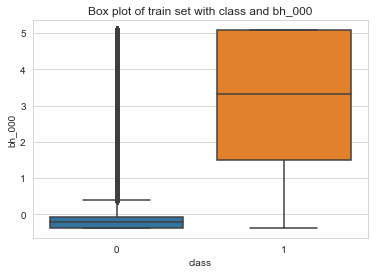

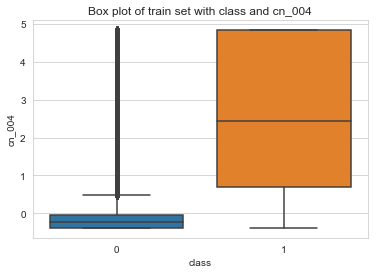

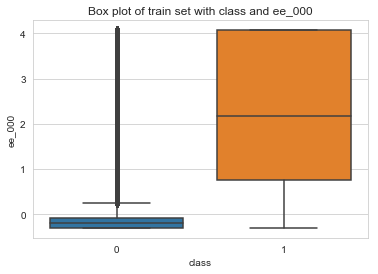

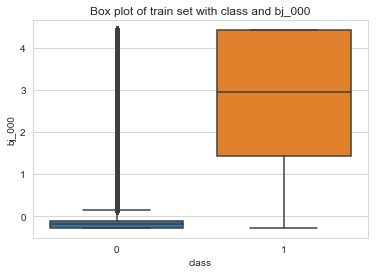

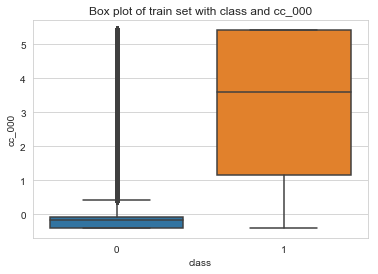

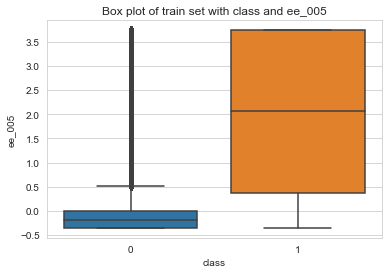

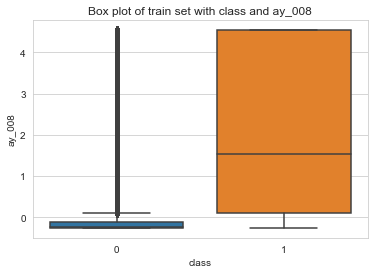

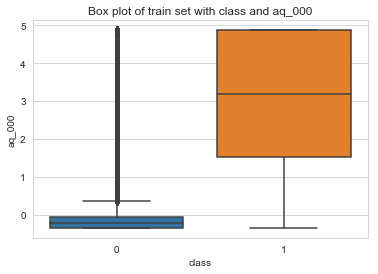

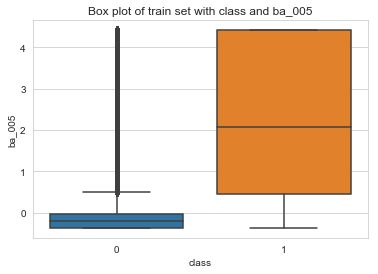

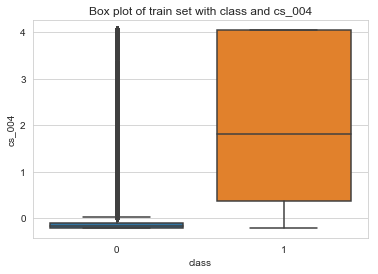

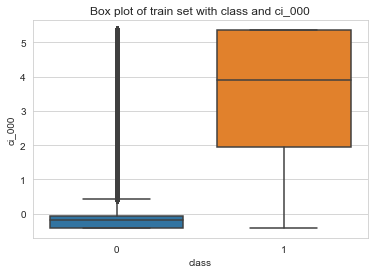

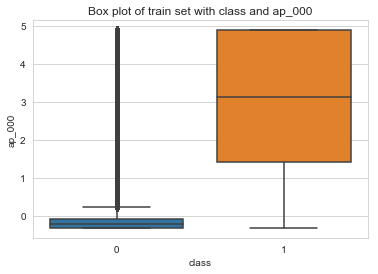

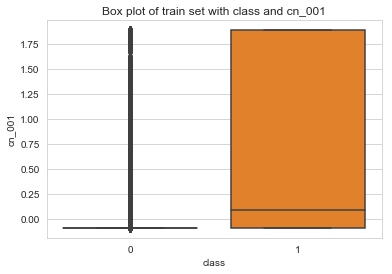

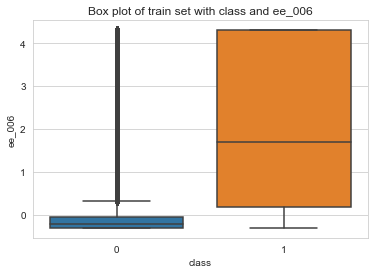

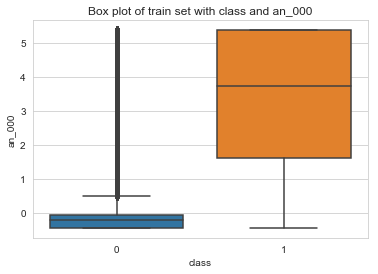

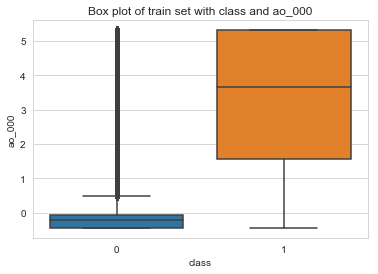

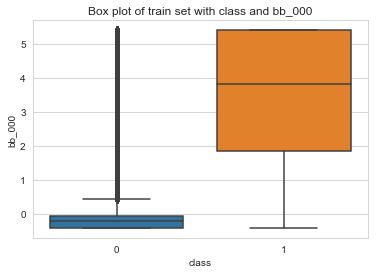

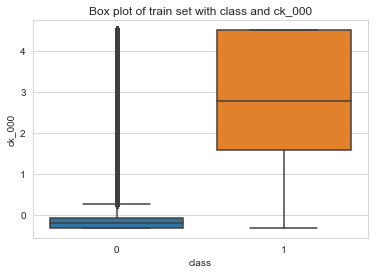

In [ ]:
for col in final_cols:
    sns.boxplot(data = train_data, x= "class", y= col)
    plt.title("Box plot of train set with class and {}".format(col))
    plt.show()

We can see from the above box-plots, each of these important features (high correlation with class label) can easily separate both classes.

**t-SNE**

EDA with tSNE to check whether the data points are separable in space or not.

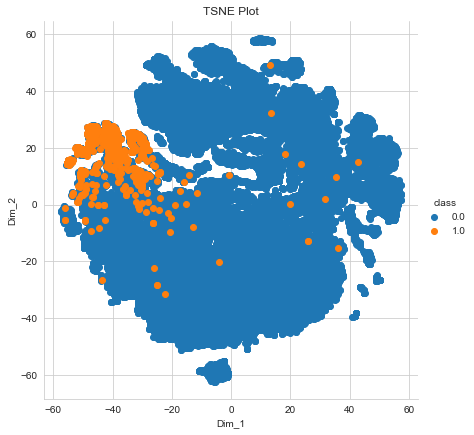

In [ ]:
tsne = TSNE(n_components=2, random_state=0, perplexity=50)
tsne_data = tsne.fit_transform(train_data.loc[:, final_cols]) 

# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, train_data['class'].values)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "class"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="class", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('TSNE Plot')
plt.show()

With the help of tSNE, we have ploted the data points in 2D to check whether the features useful in separating the classes or not. As we can see, due to class imbalance there are very few points for class-1 (orange colors) and all the class-0 points (blue points) are surrounding class-1 and even they all are overlapped. So with tSNE, we can conclude that by combining the existing features its difficult to separate the classes.

But after dealing with imbalance of dataset, it would be easy to separate as in box-plot, we have already seen that classes are getting separated for each feature values.

## Models

We have numerical 169 dimensional data and its a classification problem. We can try out logistic regression, SVM, kernel SVM,random forest and XGBoost classifier with hyper-parameter tunning using GridSearchCV.

**Metrics:**

Here we can use recall to get best hyper-parameters as we are concerned about TPR, FPR values. In addition to confusion, precision and recall matrix, we can use F1-score and log-loss for model evaluation 

In [ ]:
# Save dataframe to pickle
train_data.to_pickle("./train_data.pkl")
test_data.to_pickle("./test_data.pkl")

In [3]:
# Load dataframe from pickle
train_data = pd.read_pickle("./train_data.pkl")
test_data = pd.read_pickle("./test_data.pkl")

print(train_data.shape)
print(test_data.shape)

(60000, 170)
(16000, 170)


In [4]:
# Separate X and y values from train and test data
X_train = train_data.iloc[:, :-1].astype('float64')
X_test = test_data.iloc[:, :-1].astype('float64')
y_train = train_data.iloc[:, -1].astype('int64')
y_test = test_data.iloc[:, -1].astype('int64')

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(60000, 169)
(16000, 169)
(60000,)
(16000,)


#### Confusion Matrix

In [5]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    print("Number of misclassified points {}%".format(round(((len(test_y)-np.trace(C))/len(test_y)*100),2)))
    fp = (int)(C[0][1])
    fn = (int)(C[1][0])
    print('Number of False Positives: ', fp)
    print('Number of False Negatives: ', fn)
    cost = (10 * fp) + (500 * fn)
    print('Total Cost (cost1+cost2): ', cost)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

### Logistic Regression

In [6]:
clf = LogisticRegression(penalty='l2',class_weight='balanced', solver='liblinear', max_iter= 1000)
values = [10 ** x for x in range(-5, 4)]
parameters = {'C' : values}
grid_clf = GridSearchCV(clf, parameters, cv=3, scoring='f1_micro')
grid_clf.fit(X_train, y_train)

print(grid_clf.best_params_)

{'C': 10}


Best value for hyper-parameter 'C' is 10 for logistic regression.

In [7]:
c= grid_clf.best_params_.get('C')

-------------------------------------------------- Train set --------------------------------------------------
Log-loss:  0.31603212284598126
Micro F1-score:  0.99085
Number of misclassified points 0.92%
Number of False Positives:  174
Number of False Negatives:  375
Total Cost (cost1+cost2):  189240


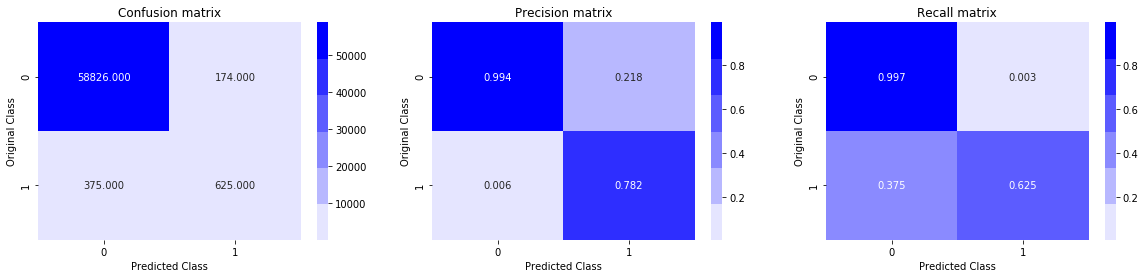

-------------------------------------------------- Test set --------------------------------------------------
Log-loss:  0.8742798688912479
Micro F1-score:  0.9746875
Number of misclassified points 2.53%
Number of False Positives:  342
Number of False Negatives:  63
Total Cost (cost1+cost2):  34920


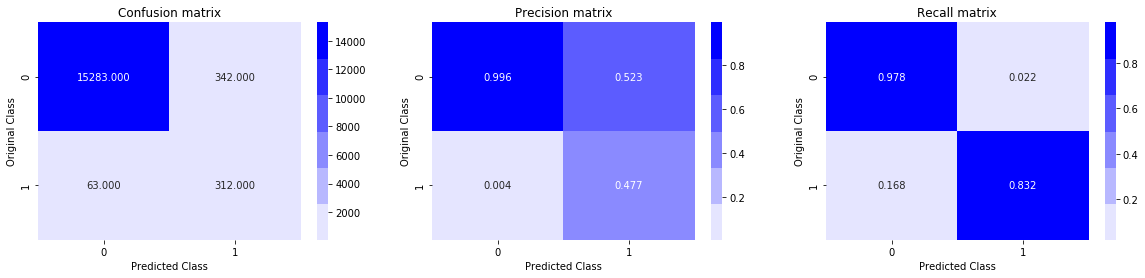

In [8]:
log_clf = LogisticRegression(penalty='l2',class_weight='balanced', C = c, solver='liblinear', max_iter= 1000)
log_clf.fit(X_train, y_train)
log_clf_cal = CalibratedClassifierCV(log_clf, method="sigmoid")
log_clf_cal.fit(X_train, y_train)
pred_y_train = log_clf_cal.predict(X_train)
pred_y_test = log_clf_cal.predict(X_test)
pickle.dump(log_clf_cal, open("lr.sav", 'wb'))

print("-"*50, "Train set", "-"*50)
print('Log-loss: ', log_loss(y_train, pred_y_train, labels=log_clf.classes_, eps=1e-15))
print('Micro F1-score: ', f1_score(y_train, pred_y_train, average='micro'))
plot_confusion_matrix(y_train, pred_y_train)
print("-"*50, "Test set", "-"*50)
print('Log-loss: ', log_loss(y_test, pred_y_test, labels=log_clf.classes_, eps=1e-15))
print('Micro F1-score: ', f1_score(y_test, pred_y_test, average='micro'))
plot_confusion_matrix(y_test, pred_y_test)

### SVC

In [ ]:
clf = SVC(class_weight='balanced')
values = [10 ** x for x in range(-5, 4)]
parameters = {'C' : values}
grid_clf = GridSearchCV(clf, parameters, cv=3, scoring='f1_micro')
grid_clf.fit(X_train, y_train)

print(grid_clf.best_params_)

{'C': 10}


Best value for hyper-parameter 'C' is 10 for svc.

In [ ]:
c= grid_clf.best_params_.get('C')

-------------------------------------------------- Train set --------------------------------------------------
Log-loss:  0.006907808585478481
Micro F1-score:  0.9998
Number of misclassified points 0.02%
Number of False Positives:  4
Number of False Negatives:  8
Total Cost (cost1+cost2):  4040


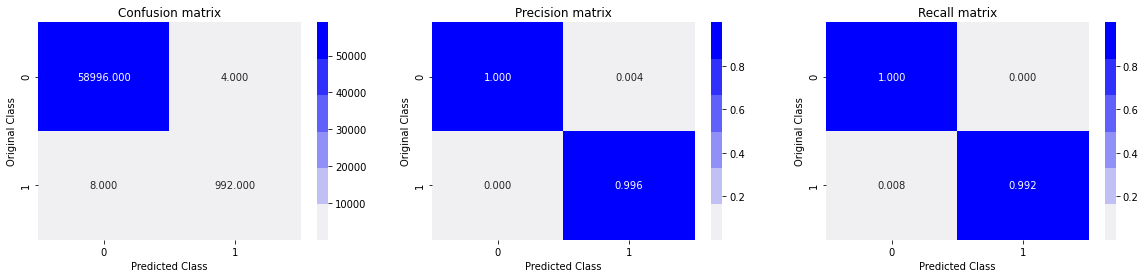

-------------------------------------------------- Test set --------------------------------------------------
Log-loss:  0.7361079717655712
Micro F1-score:  0.9786875
Number of misclassified points 2.13%
Number of False Positives:  6
Number of False Negatives:  335
Total Cost (cost1+cost2):  167560


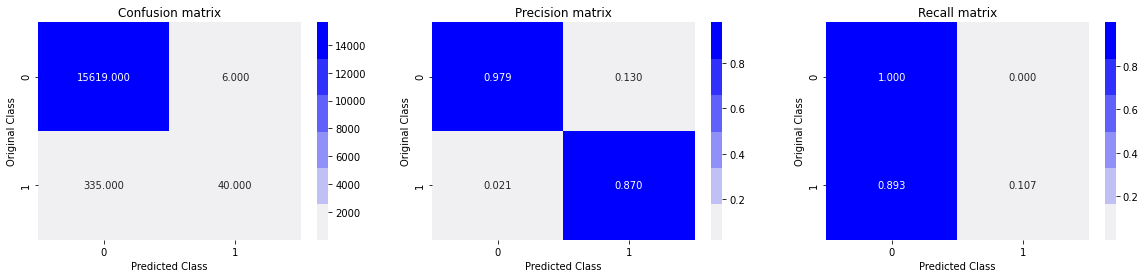

In [ ]:
svc_clf = SVC(class_weight='balanced', C = c)
svc_clf.fit(X_train, y_train)
svc_clf_cal = CalibratedClassifierCV(svc_clf, method="sigmoid")
svc_clf_cal.fit(X_train, y_train)
pred_y_train = svc_clf_cal.predict(X_train)
pred_y_test = svc_clf_cal.predict(X_test)
pickle.dump(svc_clf_cal, open("svc.sav", 'wb'))

print("-"*50, "Train set", "-"*50)
print('Log-loss: ', log_loss(y_train, pred_y_train, labels=svc_clf.classes_, eps=1e-15))
print('Micro F1-score: ', f1_score(y_train, pred_y_train, average='micro'))
plot_confusion_matrix(y_train, pred_y_train)
print("-"*50, "Test set", "-"*50)
print('Log-loss: ', log_loss(y_test, pred_y_test, labels=svc_clf.classes_, eps=1e-15))
print('Micro F1-score: ', f1_score(y_test, pred_y_test, average='micro'))
plot_confusion_matrix(y_test, pred_y_test)

### Kernel SVC

In [ ]:
clf = SVC(class_weight='balanced', kernel = 'rbf')
c_values = [10 ** x for x in range(-5, 4)]
parameters = {'C' : c_values}
grid_clf = GridSearchCV(clf, parameters, cv=3, scoring='f1_micro')
grid_clf.fit(X_train, y_train)

print(grid_clf.best_params_)

{'C': 10}


In [ ]:
c= grid_clf.best_params_.get('C')

In [6]:
clf = SVC(class_weight='balanced', C = c, kernel = 'rbf')
gamma_values = [10 ** x for x in range(-3, 3)]
parameters = {'gamma' : gamma_values}
grid_clf = GridSearchCV(clf, parameters, cv=3, scoring='f1_micro')
grid_clf.fit(X_train, y_train)

print(grid_clf.best_params_)

{'gamma': 0.01}


In [7]:
gamma= grid_clf.best_params_.get('gamma')

Best value for hyper-parameter 'C' and 'gamma' are 10 and 0.01 for kernel svc.

-------------------------------------------------- Train set --------------------------------------------------
Log-loss:  0.01496704298369135
Micro F1-score:  0.9995666666666667
Number of misclassified points 0.04%
Number of False Positives:  18
Number of False Negatives:  8
Total Cost (cost1+cost2):  4180


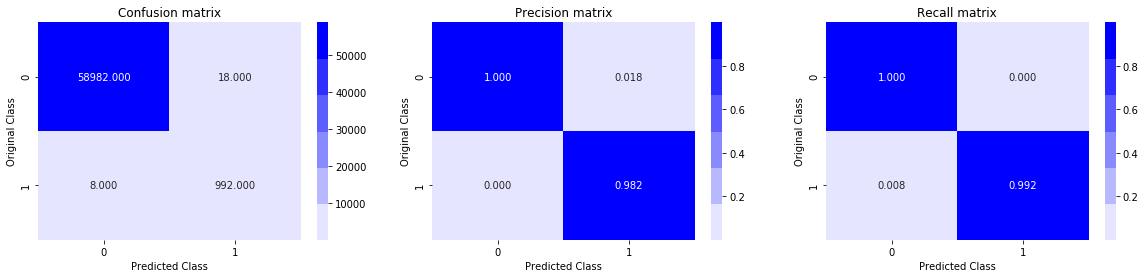

-------------------------------------------------- Test set --------------------------------------------------
Log-loss:  0.7231559306174796
Micro F1-score:  0.9790625
Number of misclassified points 2.09%
Number of False Positives:  6
Number of False Negatives:  329
Total Cost (cost1+cost2):  164560


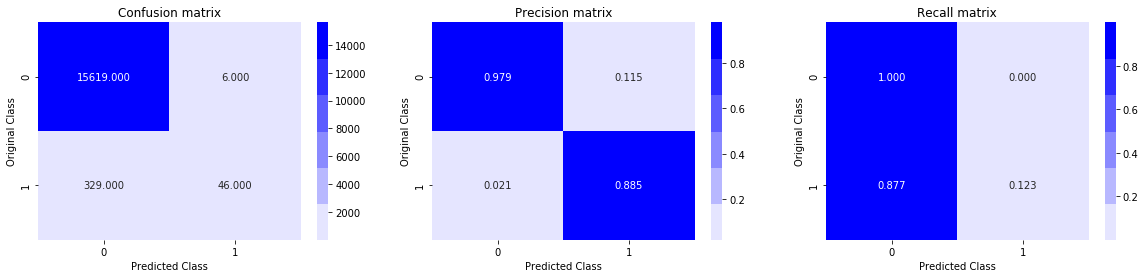

In [8]:
svc_clf = SVC(class_weight='balanced', C = 10, gamma = gamma, kernel = 'rbf')
svc_clf.fit(X_train, y_train)
svc_clf_cal = CalibratedClassifierCV(svc_clf, method="sigmoid")
svc_clf_cal.fit(X_train, y_train)
pred_y_train = svc_clf_cal.predict(X_train)
pred_y_test = svc_clf_cal.predict(X_test)
pickle.dump(svc_clf_cal, open("ksvc.sav", 'wb'))

print("-"*50, "Train set", "-"*50)
print('Log-loss: ', log_loss(y_train, pred_y_train, labels=svc_clf.classes_, eps=1e-15))
print('Micro F1-score: ', f1_score(y_train, pred_y_train, average='micro'))
plot_confusion_matrix(y_train, pred_y_train)
print("-"*50, "Test set", "-"*50)
print('Log-loss: ', log_loss(y_test, pred_y_test, labels=svc_clf.classes_, eps=1e-15))
print('Micro F1-score: ', f1_score(y_test, pred_y_test, average='micro'))
plot_confusion_matrix(y_test, pred_y_test)

### Random Forest Classifier

In [9]:
clf = RandomForestClassifier(class_weight='balanced')
parameters = {'n_estimators' : [10,50,100,500,1000,2000,3000]}
grid_clf = GridSearchCV(clf, parameters, cv=3, scoring='f1_micro')
grid_clf.fit(X_train, y_train)

print(grid_clf.best_params_)

{'n_estimators': 1000}


In [10]:
n_estimators = grid_clf.best_params_.get('n_estimators')

In [11]:
clf = RandomForestClassifier(class_weight='balanced', n_estimators=1000)
parameters = {'max_depth': [1, 5, 10, 50]}
grid_clf = GridSearchCV(clf, parameters, cv=3, scoring='f1_micro')
grid_clf.fit(X_train, y_train)

print(grid_clf.best_params_)

{'max_depth': 50}


In [12]:
max_depth = grid_clf.best_params_.get('max_depth')

Best value for hyper-parameter 'max_depth' and 'n_estimators' are 50 and 1000 for random forest.

-------------------------------------------------- Train set --------------------------------------------------
Log-loss:  9.99200722162641e-16
Micro F1-score:  1.0
Number of misclassified points 0.0%
Number of False Positives:  0
Number of False Negatives:  0
Total Cost (cost1+cost2):  0


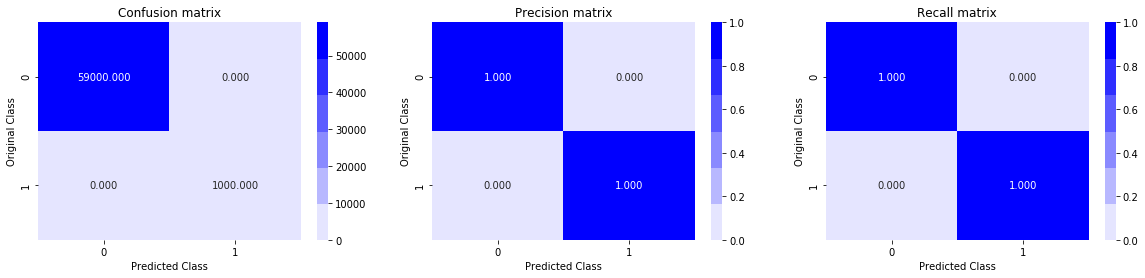

-------------------------------------------------- Test set --------------------------------------------------
Log-loss:  0.3086916633501786
Micro F1-score:  0.9910625
Number of misclassified points 0.89%
Number of False Positives:  27
Number of False Negatives:  116
Total Cost (cost1+cost2):  58270


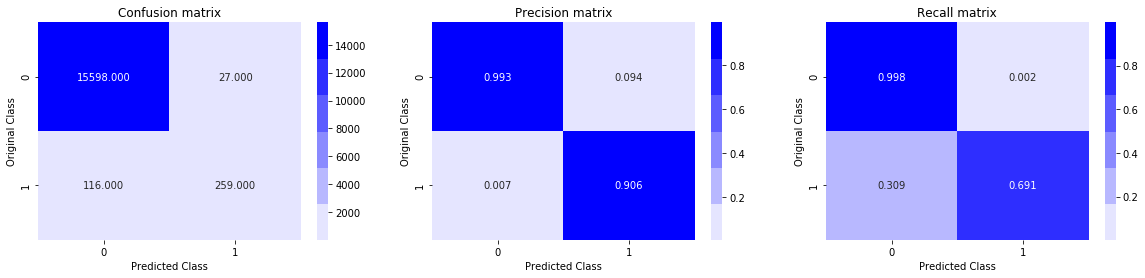

In [13]:
rfc_clf = RandomForestClassifier(class_weight='balanced', max_depth = max_depth, n_estimators = n_estimators)
rfc_clf.fit(X_train, y_train)
rfc_clf_cal = CalibratedClassifierCV(rfc_clf, method="sigmoid")
rfc_clf_cal.fit(X_train, y_train)
pred_y_train = rfc_clf_cal.predict(X_train)
pred_y_test = rfc_clf_cal.predict(X_test)
pickle.dump(rfc_clf_cal, open("rfc.sav", 'wb'))

print("-"*50, "Train set", "-"*50)
print('Log-loss: ', log_loss(y_train, pred_y_train, labels=svc_clf.classes_, eps=1e-15))
print('Micro F1-score: ', f1_score(y_train, pred_y_train, average='micro'))
plot_confusion_matrix(y_train, pred_y_train)
print("-"*50, "Test set", "-"*50)
print('Log-loss: ', log_loss(y_test, pred_y_test, labels=svc_clf.classes_, eps=1e-15))
print('Micro F1-score: ', f1_score(y_test, pred_y_test, average='micro'))
plot_confusion_matrix(y_test, pred_y_test)

### XGBClassifier

In [14]:
clf = XGBClassifier(class_weight='balanced', nthread=-1, verbosity=0)
parameters={
     'n_estimators':[100,200,500,1000,2000],
     'max_depth':[3,5,10],
}
grid_clf = RandomizedSearchCV(clf, parameters, cv=3, scoring='f1_micro', n_jobs=-1)
grid_clf.fit(X_train, y_train)

print(grid_clf.best_params_)

{'n_estimators': 2000, 'max_depth': 5}


In [15]:
max_depth = grid_clf.best_params_.get('max_depth')
n_estimators = grid_clf.best_params_.get('n_estimators')

Best value for hyper-parameter 'max_depth' and 'n_estimators' are 5 and 2000 for xgbclassifier.

-------------------------------------------------- Train set --------------------------------------------------
Log-loss:  9.99200722162641e-16
Micro F1-score:  1.0
Number of misclassified points 0.0%
Number of False Positives:  0
Number of False Negatives:  0
Total Cost (cost1+cost2):  0


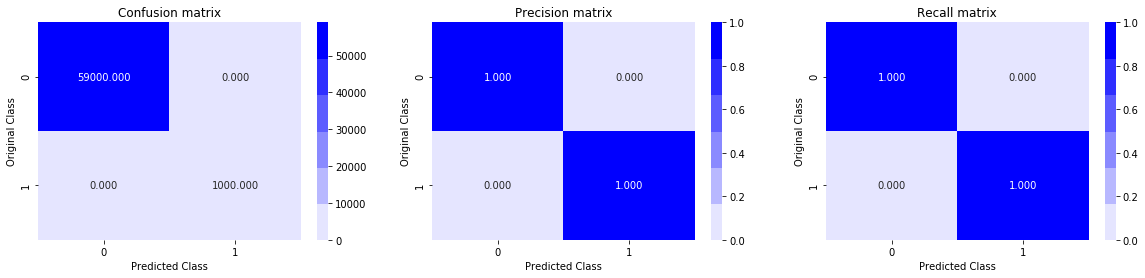

-------------------------------------------------- Test set --------------------------------------------------
Log-loss:  0.22018514929111102
Micro F1-score:  0.993625
Number of misclassified points 0.64%
Number of False Positives:  9
Number of False Negatives:  93
Total Cost (cost1+cost2):  46590


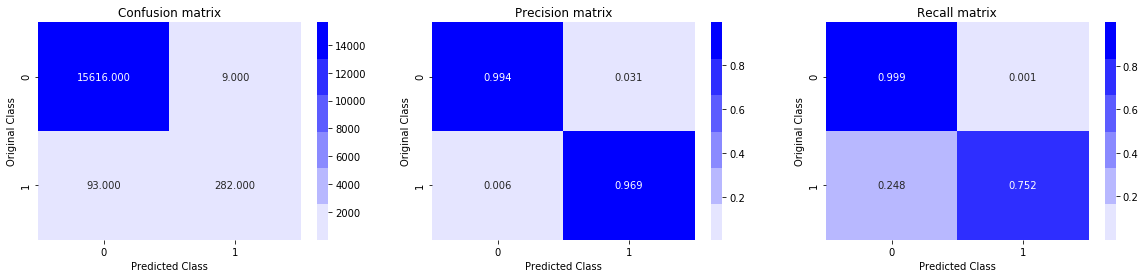

In [18]:
xgbc_clf = XGBClassifier(class_weight='balanced', max_depth = max_depth, n_estimators = n_estimators, nthread=-1, verbosity=0)
xgbc_clf.fit(X_train, y_train)
xgbc_clf_cal = CalibratedClassifierCV(xgbc_clf, method="sigmoid")
xgbc_clf_cal.fit(X_train, y_train)
pred_y_train = xgbc_clf_cal.predict(X_train)
pred_y_test = xgbc_clf_cal.predict(X_test)
pickle.dump(xgbc_clf_cal, open("xgbc.sav", 'wb'))

print("-"*50, "Train set", "-"*50)
print('Log-loss: ', log_loss(y_train, pred_y_train, labels=svc_clf.classes_, eps=1e-15))
print('Micro F1-score: ', f1_score(y_train, pred_y_train, average='micro'))
plot_confusion_matrix(y_train, pred_y_train)
print("-"*50, "Test set", "-"*50)
print('Log-loss: ', log_loss(y_test, pred_y_test, labels=svc_clf.classes_, eps=1e-15))
print('Micro F1-score: ', f1_score(y_test, pred_y_test, average='micro'))
plot_confusion_matrix(y_test, pred_y_test)

For F1-score and log-loss, RandomForest and XGBoost performer better than others.

But if we consider cost (primary objective is to minimize the cost), SVC didnt perform well. XGBoost and RandomForest performed better than SVC. But logistic regression performed better then others giving lowest cost.

### Custom stacking model

In [10]:
# Load dataframe from pickle
train_data = pd.read_pickle("./train_data.pkl")
test_data = pd.read_pickle("./test_data.pkl")

print(train_data.shape)
print(train_data.shape)

(60000, 170)
(60000, 170)


In [11]:
# Spliting data to train base models and meta model of stacking model
D1, D2 = train_test_split(train_data, test_size=0.5, stratify = train_data['class'])

print(D1.shape)
print(D2.shape)

(30000, 170)
(30000, 170)


We can choose 3 base models as logistic regression, random forest classifier, XGBClassifier as these classifers gave less cost. We can use Decision Tree as a meta classifier.

**Train base models**

In [12]:
def train_model(clf, filename, df, params= dict()):
    """This function takes model, X_train and y_train as input.
    It fits the model with hyper-tunning and calibration and save it in pickle
    """
    X_train = df.iloc[:, :-1]
    y_train = df.iloc[:,-1].astype('int64')
    modelName = filename.split(".")[0]
            
    if (len(params.keys())) > 1:
        print("Training model " + modelName + " with Randomized search.")
        cv_clf = RandomizedSearchCV(clf, params, cv=3, scoring='f1_micro', n_jobs=-1)
    else:
        print("Training model " + modelName + " with Grid search.")
        cv_clf = GridSearchCV(clf, params, cv=3, scoring='f1_micro', n_jobs=-1)  
        
    cv_clf.fit(X_train, y_train)
        
    best_params = cv_clf.best_params_
    print('Best params for model: ', best_params)
    clf.set_params(**cv_clf.best_params_)  
    clf.fit(X_train, y_train)
    clf_cal = CalibratedClassifierCV(clf, method="sigmoid")
    clf_cal.fit(X_train, y_train)
    pickle.dump(clf_cal, open(filename, 'wb'))
    print("Saved model: " + filename)

In [13]:
def predict_base_models(filenames, X_input):
    y_preds = dict()
    for filename in filenames:
        modelName = filename.split(".")[0]
        clf = pickle.load(open(filename, 'rb'))
        y_pred = clf.predict_proba(X_input)
        y_preds[modelName] = y_pred[:, 1]

    x_df = pd.DataFrame.from_dict(y_preds)
    x_df.reset_index(inplace= True)
    x_df.drop('index', axis=1, inplace=True)
    print("Y_preds df shape: ", x_df.shape)
    return x_df  

In [14]:
def trainStackingModel(classifiers, k, D1, D2, test_data):
    """This function takes models with parameters and dataframes to train and test  as input.
    It trains all base models and using them, it trains the meta model and finally use them to predict the testset data
    """
    # get base and meta model input 
    base_models = classifiers[:-1]
    meta_model = classifiers[-1]
    y_preds = list()
    base_filenames = list()
    base_dir = 'K-' + str(k)
    if not os.path.exists(base_dir):
        os.makedirs(base_dir)

    # Train base models
    for i, base_clf_inp in enumerate(base_models):
        # For each model, get the actual model and its parameters with which it will be hyper-tunned
        base_clf = base_clf_inp[0]
        base_params = base_clf_inp[1]
        # Get 50% sampled data from D1 to train the base model
        sample_D1 = D1.sample(frac= 0.5, replace= True)
        base_filename = base_dir + '/M' + str(i+1) + '_' + type(base_clf).__name__ + '.sav'
        train_model(base_clf, base_filename, sample_D1, base_params)
        base_filenames.append(base_filename)

    # Do base model predictions
    X_train_D2 = D2.iloc[:, :-1]
    y_train_D2 = D2.iloc[:,-1].astype('int64')
    meta_df = predict_base_models(base_filenames, X_train_D2)
    # train meta-model
    meta_df['Y'] = y_train_D2.values
    meta_clf = meta_model[0]
    meta_params = meta_model[1]
    meta_filename = base_dir + '/Meta' + type(meta_clf).__name__ + '.sav'
    train_model(meta_clf, meta_filename, meta_df, meta_params)

    # Test stacking model after training K models
    print("Started prediction for X_test")
    X_test = test_data.iloc[:, :-1]
    y_test = test_data.iloc[:, -1]
    base_y_preds = predict_base_models(base_filenames, X_test)
    saved_meta_clf = pickle.load(open(meta_filename, 'rb'))
    y_pred_test = saved_meta_clf.predict(base_y_preds)
    print('Log-loss: ', log_loss(y_test, y_pred_test, eps=1e-15))
    print('Micro F1-score: ', f1_score(y_test, y_pred_test, average='micro'))
    plot_confusion_matrix(y_test, y_pred_test)

We can try different combination of K models and check their performance. Models to be used are logistic regression, svc, kernel svc, decision tree, random forest and xgbClassifier. We can try different k values. (k-1 Base models and one meta-model). Models can be repeated as we have only 6 models.

In [15]:
def getAllModels():
  """This function returns all the models and their parameter values"""
  def getLogisticRrgression():
    # Model 1: Logistic Regression
    lr_model = LogisticRegression(penalty='l2',class_weight='balanced', solver='liblinear', max_iter= 1000)
    lr_params = {'C' : [10 ** x for x in range(-5, 4)]}
    return (lr_model, lr_params)

  def getSVC():
    # Model 2: SVC
    svc_model = SVC(class_weight= 'balanced')
    svc_params = {'C' : [10 ** x for x in range(-5, 4)]}
    return (svc_model, svc_params)

  def getKSVC():
    # model 3: Kernel SVC
    k_svc_model = SVC(class_weight='balanced', kernel = 'rbf')
    k_svc_params = {'C' : [10 ** x for x in range(-5, 4)], 'gamma' : [10 ** x for x in range(-3, 3)]}
    return (k_svc_model, k_svc_params) 

  def getDecisionTree():
    # Model 4: Decision Tree
    dt_model = DecisionTreeClassifier()
    dt_params = {'min_samples_split': [10, 100, 200, 500], 'max_depth': [5, 10, 50, 75]}
    return (dt_model, dt_params) 

  def getRandomForest():
    # Model 5: Random Forest
    rf_model = RandomForestClassifier(class_weight='balanced')
    rf_params = {'n_estimators' : [750,1000, 1200, 1500], 'max_depth': [5, 10, 50, 75]}
    return (rf_model, rf_params)

  def getXGBoost():
    # model 6: XGBoost
    xgbc_model = XGBClassifier(class_weight='balanced', nthread=-1, verbosity=0)
    xgbc_params = parameters={'n_estimators':[750,1000, 1200, 1500],'max_depth':[3, 5, 7, 10]}
    return (xgbc_model, xgbc_params)

  return [getLogisticRrgression, getSVC, getKSVC, getDecisionTree, getRandomForest, getXGBoost]

**For k=5, 10, 15, 20**

Started training 5 models
Training model K-5/M1_DecisionTreeClassifier with Randomized search.
Best params for model:  {'min_samples_split': 10, 'max_depth': 10}
Saved model: K-5/M1_DecisionTreeClassifier.sav
Training model K-5/M2_XGBClassifier with Randomized search.
Best params for model:  {'n_estimators': 750, 'max_depth': 7}
Saved model: K-5/M2_XGBClassifier.sav
Training model K-5/M3_DecisionTreeClassifier with Randomized search.
Best params for model:  {'min_samples_split': 10, 'max_depth': 5}
Saved model: K-5/M3_DecisionTreeClassifier.sav
Training model K-5/M4_DecisionTreeClassifier with Randomized search.
Best params for model:  {'min_samples_split': 10, 'max_depth': 5}
Saved model: K-5/M4_DecisionTreeClassifier.sav
Y_preds df shape:  (30000, 4)
Training model K-5/MetaRandomForestClassifier with Randomized search.
Best params for model:  {'n_estimators': 1000, 'max_depth': 50}
Saved model: K-5/MetaRandomForestClassifier.sav
Started prediction for X_test
Y_preds df shape:  (16000

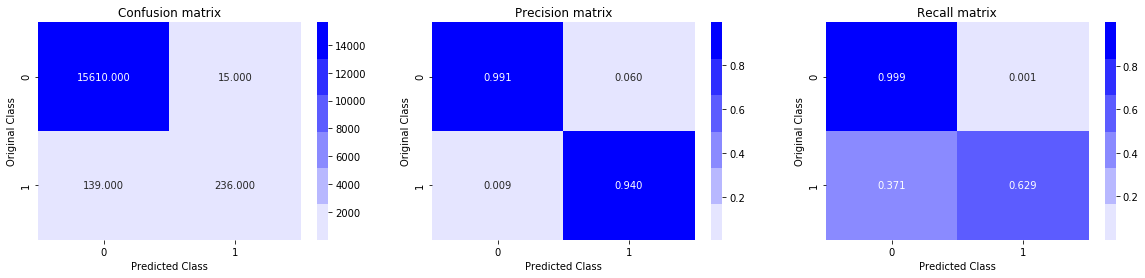

Started training 10 models
Training model K-10/M1_LogisticRegression with Grid search.
Best params for model:  {'C': 1000}
Saved model: K-10/M1_LogisticRegression.sav
Training model K-10/M2_DecisionTreeClassifier with Randomized search.
Best params for model:  {'min_samples_split': 10, 'max_depth': 50}
Saved model: K-10/M2_DecisionTreeClassifier.sav
Training model K-10/M3_SVC with Grid search.
Best params for model:  {'C': 1}
Saved model: K-10/M3_SVC.sav
Training model K-10/M4_RandomForestClassifier with Randomized search.
Best params for model:  {'n_estimators': 1500, 'max_depth': 50}
Saved model: K-10/M4_RandomForestClassifier.sav
Training model K-10/M5_RandomForestClassifier with Randomized search.
Best params for model:  {'n_estimators': 1200, 'max_depth': 50}
Saved model: K-10/M5_RandomForestClassifier.sav
Training model K-10/M6_SVC with Grid search.
Best params for model:  {'C': 1}
Saved model: K-10/M6_SVC.sav
Training model K-10/M7_XGBClassifier with Randomized search.
Best para

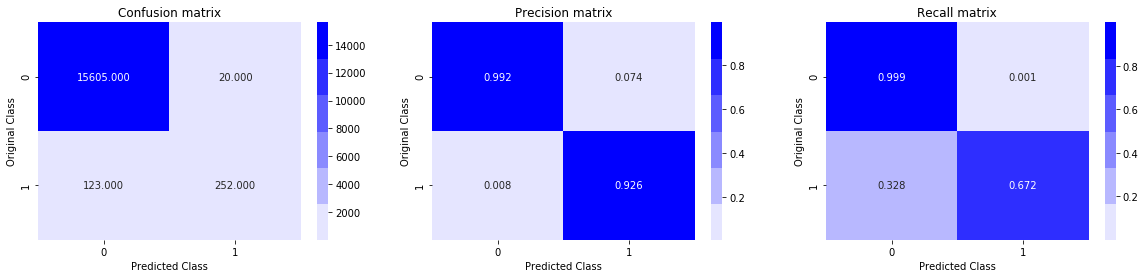

Started training 15 models
Training model K-15/M1_XGBClassifier with Randomized search.
Best params for model:  {'n_estimators': 750, 'max_depth': 5}
Saved model: K-15/M1_XGBClassifier.sav
Training model K-15/M2_SVC with Grid search.
Best params for model:  {'C': 100}
Saved model: K-15/M2_SVC.sav
Training model K-15/M3_SVC with Grid search.
Best params for model:  {'C': 10}
Saved model: K-15/M3_SVC.sav
Training model K-15/M4_XGBClassifier with Randomized search.
Best params for model:  {'n_estimators': 1000, 'max_depth': 3}
Saved model: K-15/M4_XGBClassifier.sav
Training model K-15/M5_RandomForestClassifier with Randomized search.
Best params for model:  {'n_estimators': 1000, 'max_depth': 75}
Saved model: K-15/M5_RandomForestClassifier.sav
Training model K-15/M6_RandomForestClassifier with Randomized search.
Best params for model:  {'n_estimators': 750, 'max_depth': 75}
Saved model: K-15/M6_RandomForestClassifier.sav
Training model K-15/M7_XGBClassifier with Randomized search.
Best pa

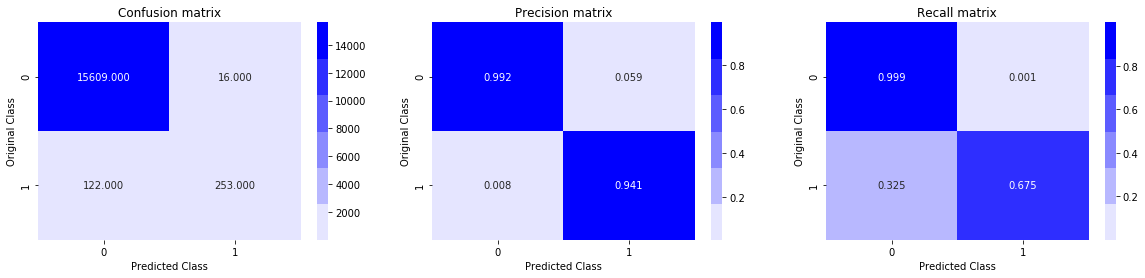

Started training 20 models
Training model K-20/M1_LogisticRegression with Grid search.
Best params for model:  {'C': 100}
Saved model: K-20/M1_LogisticRegression.sav
Training model K-20/M2_LogisticRegression with Grid search.
Best params for model:  {'C': 1000}
Saved model: K-20/M2_LogisticRegression.sav
Training model K-20/M3_DecisionTreeClassifier with Randomized search.
Best params for model:  {'min_samples_split': 10, 'max_depth': 10}
Saved model: K-20/M3_DecisionTreeClassifier.sav
Training model K-20/M4_XGBClassifier with Randomized search.
Best params for model:  {'n_estimators': 1000, 'max_depth': 7}
Saved model: K-20/M4_XGBClassifier.sav
Training model K-20/M5_DecisionTreeClassifier with Randomized search.
Best params for model:  {'min_samples_split': 10, 'max_depth': 50}
Saved model: K-20/M5_DecisionTreeClassifier.sav
Training model K-20/M6_DecisionTreeClassifier with Randomized search.
Best params for model:  {'min_samples_split': 100, 'max_depth': 75}
Saved model: K-20/M6_De

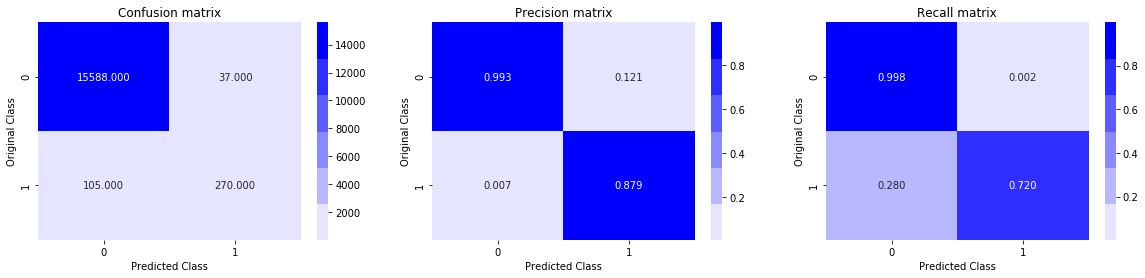

In [16]:
for k in range(5,21,5):
    print("Started training {} models".format(k))
    classifiers = getAllModels()
    no_clfs = len(classifiers)
    k_models = [classifiers[i]() for i in np.random.randint(low = 0, high = no_clfs, size = k)]
    trainStackingModel(k_models, k, D1, D2, test_data)

Stacking classifier with 20 base models (adding meta model also), gave the best result as compared to the same with less number of base models.

But with increase in k, the cost doesnt get reduced. It simply based on the type of base models used mostly. Now after stacking also, the logistic regression gave the best result alone if compared to other models and stacking models.

If we can use feasible number of base models which gave better results (logistic regression, random forest and xgbclassifier) while used individually may improve the performance of stacking model. 

Training model K-top_base/M1_LogisticRegression with Grid search.
Best params for model:  {'C': 1000}
Saved model: K-top_base/M1_LogisticRegression.sav
Training model K-top_base/M2_RandomForestClassifier with Randomized search.
Best params for model:  {'n_estimators': 1500, 'max_depth': 50}
Saved model: K-top_base/M2_RandomForestClassifier.sav
Training model K-top_base/M3_XGBClassifier with Randomized search.
Best params for model:  {'n_estimators': 750, 'max_depth': 7}
Saved model: K-top_base/M3_XGBClassifier.sav
Y_preds df shape:  (30000, 3)
Training model K-top_base/MetaDecisionTreeClassifier with Randomized search.
Best params for model:  {'min_samples_split': 500, 'max_depth': 5}
Saved model: K-top_base/MetaDecisionTreeClassifier.sav
Started prediction for X_test
Y_preds df shape:  (16000, 3)
Log-loss:  0.31948608044521537
Micro F1-score:  0.99075
Number of misclassified points 0.92%
Number of False Positives:  48
Number of False Negatives:  100
Total Cost (cost1+cost2):  50480


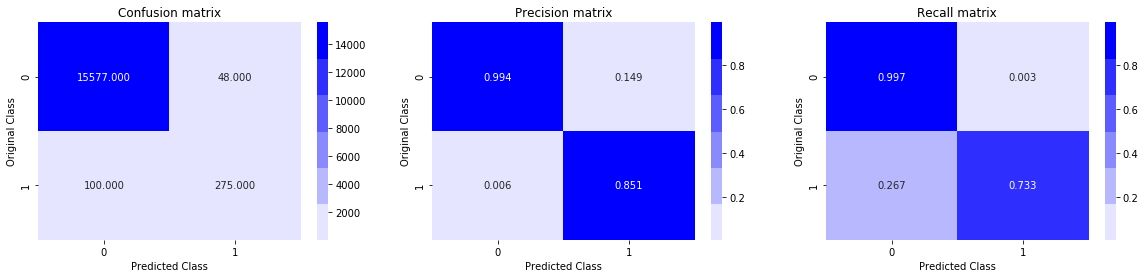

In [17]:
classifiers = getAllModels()
k_models = list()
# use logistic regression, random forest and xgboot as base models and decision tree as meta model
k_models.append(classifiers[0]())
k_models.append(classifiers[-2]())
k_models.append(classifiers[-1]())
k_models.append(classifiers[-3]())

trainStackingModel(k_models, 'top_base', D1, D2, test_data)

So we can consider Logistic regression with whole training dataset with proper hyper-parameter tunning (C: 10) as our best model.